In [70]:
import numpy as np
import torch
import os
import pickle
import cv2
import torch
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
%matplotlib inline

(32, 32, 3)


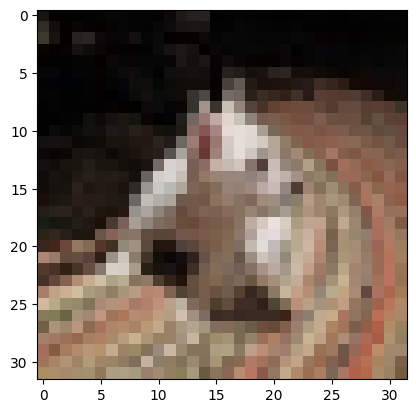

In [14]:
img=cv2.imread(r"F:\All Data\test_cnn_dataset\dogs\8001.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(32,32),cv2.INTER_CUBIC)
print(img.shape)
plt.imshow(img)

In [3]:
def image_loader(image_path,image_size):
    img=cv2.imread(image_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,image_size,cv2.INTER_CUBIC)
    return img

In [4]:
def get_image(dataset,image_size):
    folders = os.listdir(dataset)
    data = []
    labels = []

    for i, folder in enumerate(folders):
        folder_path = os.path.join(dataset, folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            image=image_loader(img_path,image_size)  # Resize the image to match VGG input size
            data.append(np.array(image))
            labels.append(i)  # Assign label based on the folder index

    data = np.array(data)
    labels = np.array(labels)

    return data,labels

In [5]:
x,y=get_image(r"F:\All Data\test_cnn_dataset",(32,32))

In [6]:
pytorch_tensor = torch.from_numpy(x)

# Print the tensor
print(pytorch_tensor)

tensor([[[[204, 206, 205],
          [201, 203, 202],
          [203, 204, 206],
          ...,
          [ 20,  22,  19],
          [ 15,  17,  14],
          [ 10,  12,   9]],

         [[197, 198, 200],
          [204, 205, 207],
          [205, 206, 208],
          ...,
          [ 18,  20,  15],
          [ 20,  22,  17],
          [  9,  11,   6]],

         [[202, 203, 205],
          [204, 205, 207],
          [195, 196, 198],
          ...,
          [ 25,  27,  22],
          [ 19,  21,  16],
          [ 11,  13,   8]],

         ...,

         [[213, 214, 219],
          [212, 213, 217],
          [213, 214, 218],
          ...,
          [153, 147, 125],
          [155, 149, 127],
          [154, 148, 126]],

         [[213, 214, 219],
          [212, 213, 217],
          [214, 215, 219],
          ...,
          [161, 156, 136],
          [157, 152, 130],
          [156, 151, 129]],

         [[211, 212, 217],
          [210, 211, 215],
          [211, 212, 214],
         

In [7]:
def conv_block(input,
               number_of_filter,
               kernel_size,
               stride=1,
               padding=1,
               activation=nn.ReLU(),
               max_pool=True,
               batch_norm=True):
    
    conv_ft=layer=activation(nn.Conv2d(in_channels=input,
                            out_channels=number_of_filter,
                            kernel_size=kernel_size,
                            stride=stride,
                            padding=padding,
                            ))
    
    
    if max_pool:
        layer=nn.MaxPool2d(kernel_size=(2,2),
                           stride=(2,2),
                           padding=padding)(layer)
        
    if batch_norm:
        layer=nn.BatchNorm1d()(layer)

    return layer, conv_ft


In [8]:
def dense_block(inputs,
               out_features,
               activation=nn.ReLU(),
               dropout=None,
               batch_norm=True):
    
    dense_ft=layer=activation(nn.Linear(in_features=inputs,
                             out_features=out_features))
    
    if batch_norm:
        layer=nn.BatchNorm1d()(layer)
    
    if dropout is not None:
        layer=nn.Dropout(dropout)(layer)

    return layer, dense_ft

In [9]:
class rvr_image(nn.modules):
    def __init__(self,
                 image_size,
                 droupout,
                 num_classes):
        super(rvr_image,self).__init__()
        
        self.droupout=droupout
        self.num_classes=num_classes
        self.image_size=image_size
        
        conv_b1,self.conv_b1_ft=conv_block(input =self.image_size,
                                           number_of_filter=64,
                                           kernel_size=3,
                                           stride=1,
                                           padding=1,
                                           activation=nn.ReLU(),
                                           max_pool=True,
                                           batch_norm=True)
        
        conv_b2,self.conv_b2_ft=conv_block(input =conv_b1,
                                           number_of_filter=128,
                                           kernel_size=3,
                                           stride=1,
                                           padding=1,
                                           activation=nn.ReLU(),
                                           max_pool=True,
                                           batch_norm=True)
        
        conv_b3,self.conv_b3_ft=conv_block(input =conv_b2,
                                           number_of_filter=256,
                                           kernel_size=5,
                                           stride=1,
                                           padding=1,
                                           activation=nn.ReLU(),
                                           max_pool=True,
                                           batch_norm=True)
        
        conv_b4,self.conv_b4_ft=conv_block(input =conv_b3,
                                           number_of_filter=512,
                                           kernel_size=5,
                                           stride=1,
                                           padding=1,
                                           activation=nn.ReLU(),
                                           max_pool=True,
                                           batch_norm=True)

        flat_layer=nn.Flatten(conv_b4)

        dense_b1,dense_b1_ft=dense_block(flat_layer,
                                         out_features=128,
                                         activation=nn.ReLU(),
                                         dropout=self.dropout,
                                         batch_norm=True)

        dense_b2,dense_b2_ft=dense_block(dense_b1,
                                         out_features=256,
                                         activation=nn.ReLU(),
                                         dropout=self.dropout,
                                         batch_norm=True)
        
        dense_b3,dense_b3_ft=dense_block(dense_b2,
                                         out_features=512,
                                         activation=nn.ReLU(),
                                         dropout=self.dropout,
                                         batch_norm=True)
        
        dense_b4,dense_b4_ft=dense_block(dense_b3,
                                         out_features=1024,
                                         activation=nn.ReLU(),
                                         dropout=self.dropout,
                                         batch_norm=True)
        
        self.logits=nn.Linear(in_features=dense_b4,out_features=self.num_classes)
        self.pred=nn.Softmax(dim=1)
        
    def forward(self,x):
        x=self.conv_b1_ft(x)
        x=self.conv_b2_ft(x)
        x=self.conv_b3_ft(x)
        x=self.conv_b4_ft(x)
        x=torch.flatten(x,1)
        x=self.dense_b1_ft(x)
        x=self.dense_b2_ft(x)
        x=self.dense_b3_ft(x)
        x=self.dense_b4_ft(x)
        x=self.logits(x)
        x=self.pred(x)
        return x
        
        

TypeError: module() takes at most 2 arguments (3 given)

In [ ]:
class rvr_image(nn.modules):
    def __init__(self):
        super(rvr_image,self).__init__()

In [68]:
import torch.nn as nn
import torch

class Model(nn.Module):
    def __init__(self,
                in_channels,
                out_channels,
                kernel_size,
                num_classes,
                dropout_rate):
        super(Model, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(out_channels, 2 * out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(2 * out_channels),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(2 * out_channels, 4 * out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * out_channels),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(4 * out_channels, 8 * out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8 * out_channels),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
        )


        # Flatten the output of the last convolutional block
        self.flatten = nn.Flatten()

        # Linear layer for classification
        self.fc1 = nn.Linear(in_features=4608, out_features=128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=256, out_features=512)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(in_features=512, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        print("int",x.shape)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        print("before flatten",x.shape)
        x = self.flatten(x)
        print("after flat",x.shape)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [65]:
class ImageDataset(Dataset):
    def __init__(self, dataset_path, image_size, transform=None):
        self.dataset_path = dataset_path
        self.image_size = image_size
        self.transform = transform
        self.folders = os.listdir(dataset_path)
        self.data = []
        self.labels = []

        for i, folder in enumerate(self.folders):
            folder_path = os.path.join(dataset_path, folder)
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                image=image_loader(img_path,image_size)
                self.data.append(image)
                self.labels.append(i)
            
            

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        
        image = torch.from_numpy(image).float()  # Convert NumPy array to PyTorch tensor
        image= image.permute(2,0,1)
        return image, label

def get_dataloader(dataset_path, image_size, batch_size, shuffle=True):
    dataset = ImageDataset(dataset_path, image_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Example usage:
dataset_path = r"F:\All Data\test_cnn_dataset"
image_size = (32, 32)
batch_size = 32

dataloader = get_dataloader(dataset_path, image_size, batch_size)
"""
# Iterate through the dataloader
for images, labels in dataloader:
    # Process the images and labels
    print(images.shape)  # Output: torch.Size([32, 3, 224, 224])
    print(labels)
"""

torch.Size([32, 3, 32, 32])
tensor([1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 0, 0, 1, 0, 1, 2, 2, 2, 1, 0, 1, 0, 0, 2,
        2, 1, 0, 0, 0, 1, 1, 0])
torch.Size([32, 3, 32, 32])
tensor([2, 1, 2, 0, 0, 1, 1, 2, 0, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 1, 2, 1, 1,
        0, 2, 0, 2, 2, 2, 2, 1])
torch.Size([32, 3, 32, 32])
tensor([0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 0, 0,
        1, 2, 0, 0, 1, 0, 2, 0])
torch.Size([32, 3, 32, 32])
tensor([1, 2, 1, 0, 0, 2, 0, 0, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 1, 2,
        1, 2, 2, 1, 2, 2, 0, 1])
torch.Size([32, 3, 32, 32])
tensor([2, 1, 0, 1, 2, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 2, 0, 0, 0, 2, 2,
        1, 0, 0, 2, 0, 0, 2, 0])
torch.Size([32, 3, 32, 32])
tensor([1, 0, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 1, 1, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2,
        0, 0, 1, 0, 0, 0, 0, 1])
torch.Size([32, 3, 32, 32])
tensor([1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 2, 2, 2, 2, 1, 1,
        1, 1, 0, 2, 2, 0, 1, 1])
torch.Size([3

In [66]:
images.shape

torch.Size([16, 3, 32, 32])

In [67]:
num_epochs=1
model=Model(in_channels=3,out_channels=64,kernel_size=3,num_classes=3)
optimizer=torch.optim.Adadelta(model.parameters())
criterion=nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    for images, labels in dataloader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")


int torch.Size([32, 3, 32, 32])
before flatten torch.Size([32, 512, 3, 3])
after flat torch.Size([32, 4608])
int torch.Size([32, 3, 32, 32])
before flatten torch.Size([32, 512, 3, 3])
after flat torch.Size([32, 4608])
int torch.Size([32, 3, 32, 32])
before flatten torch.Size([32, 512, 3, 3])
after flat torch.Size([32, 4608])
int torch.Size([32, 3, 32, 32])
before flatten torch.Size([32, 512, 3, 3])
after flat torch.Size([32, 4608])
int torch.Size([32, 3, 32, 32])
before flatten torch.Size([32, 512, 3, 3])
after flat torch.Size([32, 4608])
int torch.Size([32, 3, 32, 32])
before flatten torch.Size([32, 512, 3, 3])
after flat torch.Size([32, 4608])
int torch.Size([32, 3, 32, 32])
before flatten torch.Size([32, 512, 3, 3])
after flat torch.Size([32, 4608])
int torch.Size([32, 3, 32, 32])
before flatten torch.Size([32, 512, 3, 3])
after flat torch.Size([32, 4608])
int torch.Size([32, 3, 32, 32])
before flatten torch.Size([32, 512, 3, 3])
after flat torch.Size([32, 4608])
int torch.Size([32,

In [73]:
summary(model, (3, 32, 32))


int torch.Size([2, 3, 32, 32])
before flatten torch.Size([2, 512, 3, 3])
after flat torch.Size([2, 4608])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         MaxPool2d-4           [-1, 64, 17, 17]               0
            Conv2d-5          [-1, 128, 17, 17]          73,856
              ReLU-6          [-1, 128, 17, 17]               0
       BatchNorm2d-7          [-1, 128, 17, 17]             256
         MaxPool2d-8            [-1, 128, 9, 9]               0
            Conv2d-9            [-1, 256, 9, 9]         295,168
             ReLU-10            [-1, 256, 9, 9]               0
      BatchNorm2d-11            [-1, 256, 9, 9]             512
        MaxPool2d-12            [-1, 256, 5, 5]              

In [44]:
# Example usage:
model = Model(in_channels=3, out_channels=64, kernel_size=3,num_classes=3)

# Input tensor (assuming image data)
input_tensor = torch.randn(1, 3, 32, 32)

# Pass the input tensor through the model
output = model(input_tensor)

# Print the output shape
print(output.shape)

torch.Size([1, 512, 3, 3])
torch.Size([1, 4608])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4608 and 3072x128)